In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
plt.rcParams['figure.figsize'] = [17, 8]

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
from dataset.audio_dataset import AudioData, default
from model.autoencoder.encoder import Encoder
from model.autoencoder.decoder import Decoder
from model.ddsp.harmonic_oscillator import OscillatorBank
from train.train import AutoEncoder
from config.default import Config

In [4]:
default = Config()

In [5]:
dataset = AudioData(clear=False)

Loading presaved dataset...


In [6]:
audio = dataset[0]
audio.shape

torch.Size([88064])

In [7]:
loader = DataLoader(dataset, 10, shuffle=True)

In [8]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([10, 88064])


In [9]:
batch = batch

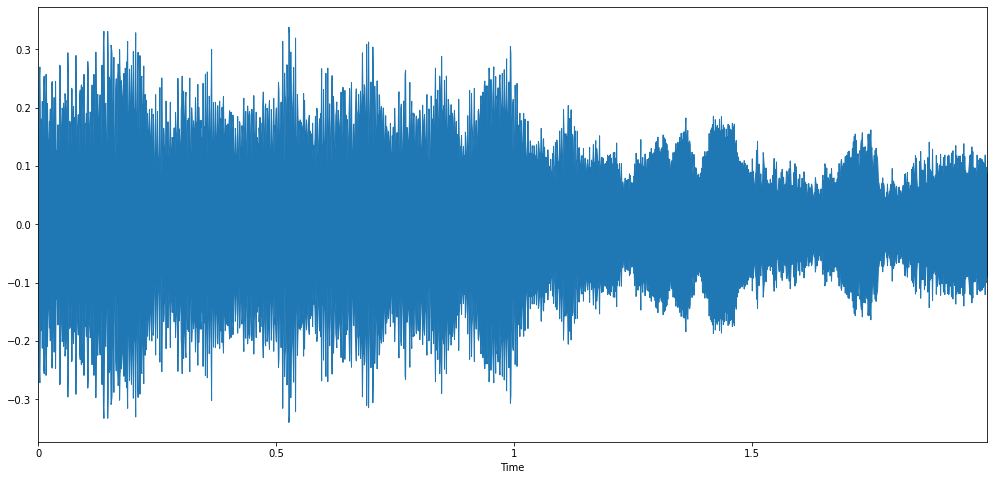

In [10]:
librosa.display.waveplot(batch[0].cpu().numpy(), sr=default.sample_rate)

In [11]:
ipd.Audio(data=batch[0].cpu().numpy(), rate=default.sample_rate)

In [12]:
encoder = Encoder()

In [13]:
z = encoder(batch)

In [ ]:
z['probabilities'].shape

In [ ]:
plt.plot(z['scaled_bins'][0].cpu().numpy())
plt.plot(z['harmonicity'][0].cpu().numpy())
plt.plot(z['loudness'][0].cpu().numpy())

In [ ]:
librosa.display.specshow(z['probabilities'][0].cpu().numpy().T, sr=default.sample_rate, hop_length=default.hop_length)

In [ ]:
ae = AutoEncoder().cuda()

In [ ]:
with torch.no_grad():
    result_hat = ae(batch)

In [ ]:
decoder = Decoder().cuda()

In [ ]:
with torch.no_grad():
    z_hat = decoder(z)

In [ ]:
with torch.no_grad():
    z = encoder(result_hat)

In [ ]:
plt.plot(z['scaled_bins'][0].cpu().numpy())
plt.plot(z['harmonicity'][0].cpu().numpy())
plt.plot(z['loudness'][0].cpu().numpy())

In [ ]:
ipd.Audio(data=result_hat[0].cpu().numpy(), rate=default.sample_rate)

In [108]:
def cents_map(x):
    return x * 20 + 1997.3794084376191

In [109]:
cents_map(0), cents_map(359)

(1997.379408437619, 9177.379408437619)